# University of Nevada Reno Geodetic Lab GPS Time Series Analysis

### [http://geodesy.unr.edu](http://geodesy.unr.edu)


### 2012 strainmeter anomaly

In [202]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt

import gpstools as gps

import geopandas as gpd
from shapely.geometry import Point

import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

import matplotlib.dates as pltdate


In [356]:
plt.rcParams['font.size'] = 16
plt.style.use('seaborn-white')
#%matplotlib notebook
%matplotlib inline
#%qtconsole

# Simple Map showing station location

In [6]:
def plot_map():
    plot_CRS = ccrs.PlateCarree()
    geodetic_CRS = ccrs.Geodetic()

    # frame station by box of several degrees
    frame=5 #degrees
    x0, y0 = plot_CRS.transform_point(-126, 45, geodetic_CRS)
    x1, y1 = plot_CRS.transform_point(-122, 48, geodetic_CRS)

    fig,ax = plt.subplots(figsize=(8,8), dpi=100, 
                          subplot_kw=dict(projection=plot_CRS))

    ax.set_xlim((x0, x1))
    ax.set_ylim((y0, y1))

    ax.stock_img() # very low-res, but fast!
    ax.coastlines(resolution='50m') #10m is highest res

    states = cfeature.NaturalEarthFeature(scale='50m',
                                     category='cultural',
                                     name='admin_1_states_provinces_lakes')
    ax.add_feature(states, facecolor='none', edgecolor='k',linewidth=0.5)

    gl = ax.gridlines(ccrs.PlateCarree(), draw_labels=True,
                      linewidth=0.5, color='gray', alpha=0.5, linestyle='-')
    gl.xlabels_top = False
    gl.ylabels_left = False
    #gl.xlines = False
    #gl.xlocator = mticker.FixedLocator([-180, -45, 0, 45, 180])
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    return ax

In [7]:
ax = plot_map()

In [314]:
# Find other GPS stations in the vicinity
dfS = gps.ungl.load_stations()
pad = 1 #degree
minlat = 45
maxlat = 48
minlon = -126
maxlon = -122
subset = dfS.query('(@minlat < lat < @maxlat) and (@minlon < lon < @maxlon)')


# Cull to the same time period
# for example, active after 2010, with minimal data gaps?
after = pd.Timestamp('2010-08-01')
subset = subset.query('end > @after')


In [315]:
print('{} stations in the vicinity'.format(len(subset)))
subset.head()

144 stations in the vicinity


,site,lat,lon,height,start,end
1052,BCIT,47.6142,-122.1915,45.747,2008-06-09,2017-01-21
1185,BFIR,47.6174,-122.1255,121.683,2008-06-10,2017-01-21
1242,BILS,47.5393,-124.2525,38.353,2011-11-08,2017-01-21
1599,BSUM,47.5542,-122.1323,336.298,2008-06-09,2017-01-21
1901,CATH,46.1973,-123.3673,56.364,2007-05-04,2015-07-26


In [10]:
def load_pbo_strainmeters():
    ''' https://www.unavco.org/data/strain-seismic/bsm-data/bsm-data.html '''
    df = pd.read_csv('PBO_bsm_coords.txt', comment='#', names=['id','name','lat','lon','elev'])
    return df

In [11]:
# Get strain meters in area of interest
dfStrain = load_pbo_strainmeters()
dfStrain.head()
dfStrain = dfStrain.query('(@minlat < lat < @maxlat) and (@minlon < lon < @maxlon)')
B022 = dfStrain.query('id == "B022" ')
dfStrain

,id,name,lat,lon,elev
10,B013,PnyCrk013bwa2007,47.813000,-122.910797,75.3
11,B014,quinlt014bwa2008,47.513302,-123.812500,64.7
12,B017,flinkm017bwa2007,46.995998,-123.557503,33.9
13,B018,delphi018bor2006,46.979500,-123.020302,10.0
14,B019,waldrf019bwa2008,46.652699,-123.651802,9.0
15,B020,wirkla020bwa2008,46.382702,-123.844498,31.2
16,B022,seaside22bor2006,45.954609,-123.931053,10.0
17,B023,cataln023bor2008,46.111198,-123.078697,177.4
18,B024,kuntza024bor2006,45.637798,-123.855797,37.7
19,B026,roosbc026bor2007,45.309353,-123.823051,232.0


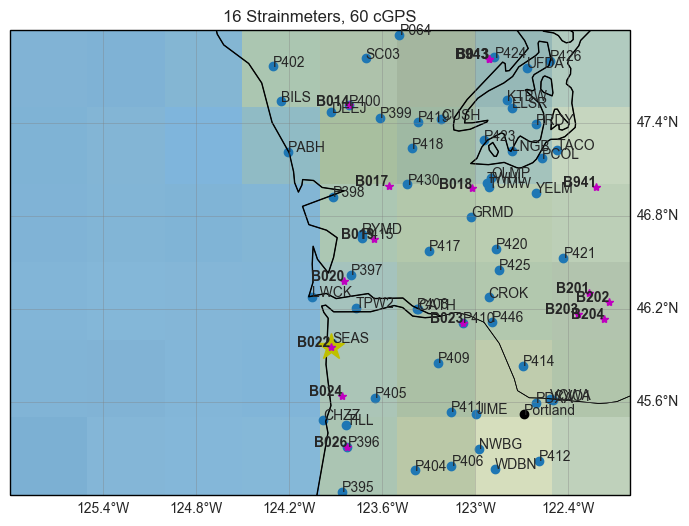

In [287]:
# NOTE: cartopy is smart enough to figure out lon -127 or 227 converntions
ax = plot_map()
ax.scatter(subset.lon, subset.lat,  transform=ccrs.Geodetic())
for i in range(len(subset)):
    ax.text(subset.lon.iloc[i], subset.lat.iloc[i], subset.site.iloc[i], transform=ccrs.Geodetic())

ax.plot(B022.lon, B022.lat, 'y*', ms=20, transform=ccrs.Geodetic())
#ax.text(B022.lon, B022.lat, 'B022', fontweight='bold', transform=ccrs.Geodetic())

#plot and label all strain meters
for i,row in dfStrain.iterrows():
    ax.plot(row.lon, row.lat, 'm*', transform=ccrs.Geodetic())
    ax.text(row.lon, row.lat, row.id, fontweight='bold', ha='right', transform=ccrs.Geodetic())

plt.title('{} Strainmeters, {} cGPS'.format(len(dfStrain), len(subset)))
#plt.xlim(-126, -122)
#plt.ylim(45,48)

# Add a few cities
ax.plot(-122.681944, 45.52, 'ko', transform=ccrs.Geodetic())
ax.text(-122.681944, 45.52, 'Portland', transform=ccrs.Geodetic())

# Strainmeters of interest:
# B022, B020, B019, B024

# GPS of interest:  NOTE: B022 seems colocated with P407
# (SEAS, P407), P405, FTS6, TPW2, LWCK, IWAC, P397, P408, CATH

# N-S profile of GPS stations that should show ETS event
#['P064', 'P419', 'P418', 'P430', 'P417', 'P408', 'P409', 'P411', 'P406']

In [317]:
# Check time series for nearest stations
station = 'P407' 
#station = 'SEAS'
refframe= 'NA12'
# Download data
tenv3 = gps.ungl.download_data(station, refframe, overwrite=True)
# Load the timeseries as pandas dataframe
df = gps.ungl.load_tenv3(tenv3)
titlestr = '{} ({}) [mm]'.format(station, refframe)

Overwriting P407


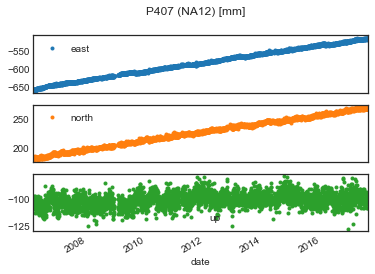

In [318]:
axes = df.plot(y=['east','north','up'], style='.' ,sharex=True, subplots=True, title=titlestr)

In [319]:
df1,df2= gps.ungl.load_steps(station)
print(df1)
print(df2)

Empty DataFrame
Columns: [site, date, code, note]
Index: []
   site       date  code  thresh_d  distance  mag          id
0  P407 2001-02-28     2   398.107   161.607  6.8  uw10530748
1  P407 2005-06-15     2   630.957   543.358  7.2  usp000dt25
2  P407 2012-10-28     2  1258.925   961.680  7.8  usp000juhz


In [320]:
# get distance to these other stations
geom = subset.apply(lambda row: Point(row.lon, row.lat), axis=1)
gf = gpd.GeoDataFrame(subset, crs="+init=epsg:4326", geometry=geom)
#gf['distance'] = gf.distance(Point(dfs.lon,dfs.lat))
 #NOTE this is in weird degree units. switch to UTM
#EPSG:32610 WGS84 10North

gf = gf.to_crs({'init': 'epsg:32610'})

site = gf.query('site == @station')

gf['distance'] = gf.distance( site.geometry.iloc[0])/1e3 #distance in kilometres
gf.sort_values('distance')

,site,lat,lon,height,start,end,geometry,distance
10471,P407,45.9546,-123.9310,-13.123,2006-03-01,2017-01-21,POINT (427851.679520616 5089424.611521271),0.000000
12560,SEAS,45.9842,-123.9224,-12.049,2008-08-24,2017-01-19,POINT (428556.2081854839 5092705.594333944),3.355772
3848,FTS5,46.2049,-123.9561,-13.712,2008-03-27,2016-08-09,POINT (426240.8533518889 5117257.934443687),27.879896
3849,FTS6,46.2052,-123.9560,-13.502,2008-03-26,2016-08-09,POINT (426248.9694033121 5117291.174587799),27.912614
13873,TPW2,46.2074,-123.7684,-14.973,2000-03-31,2017-01-21,POINT (440723.7789708609 5117378.40361983),30.775078
7794,LWCK,46.2781,-124.0538,39.051,2012-02-11,2015-07-26,POINT (418811.7921511952 5125486.677437812),37.177845
5536,IWAC,46.3059,-124.0394,-14.174,2007-12-07,2011-11-30,POINT (419961.721123543 5128560.936971465),39.923720
10469,P405,45.6293,-123.6438,955.650,2006-07-29,2017-01-21,POINT (449817.2417543394 5053063.063454065),42.481150
10472,P408,46.2005,-123.3766,35.273,2005-06-30,2017-01-21,POINT (470944.5074574228 5116393.731236944),50.836259
1901,CATH,46.1973,-123.3673,56.364,2007-05-04,2015-07-26,POINT (471660.376764407 5116034.815176642),51.257242


P407 already dowloaded... skipping
SEAS already dowloaded... skipping
FTS5 already dowloaded... skipping
FTS6 already dowloaded... skipping
TPW2 already dowloaded... skipping


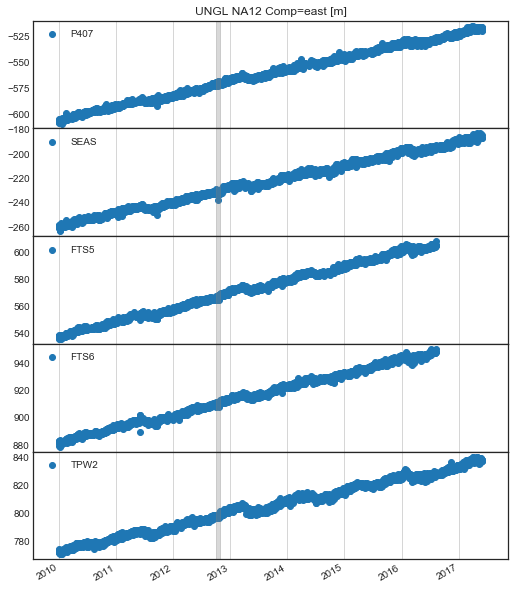

In [321]:
# Make a comparison plot for particular component, list of stations
sites = ['P407', 'SEAS', 'FTS5', 'FTS6', 'TPW2']#, 'LWCK', 'IWAC', 'P405'] #<40km 
comp = 'east'
fig,axes = plt.subplots(len(sites),1, sharex=True, figsize=(8.5,11))
for i,site in enumerate(sites):
    ax = axes[i]
    tenv3 = gps.ungl.download_data(site, refframe, overwrite=False)
    tmp = gps.ungl.load_tenv3(tenv3)
    tmp = tmp['2010/01/01':'2017/06/01']#specific time range
    ax.scatter(tmp.index, tmp[comp],label=site)
    ax.legend(loc='upper left')
    ax.grid(axis='x')
    
    # Highlight strain increase
    ax.axvspan(pd.to_datetime('2012/10/01'), pd.to_datetime('2012/10/30'), color='gray', alpha=0.3)

axes[0].set_title('UNGL NA12 Comp={} [m]'.format(comp))
fig.subplots_adjust(hspace=0, wspace=0)
fig.autofmt_xdate()

In [27]:
%matplotlib inline

# Detrended East

P407 already dowloaded... skipping
east Rate [mm/yr]=12039.560317086878

/Users/scott/Documents/GitHub/gpstools/analysis.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df['ints'] = df.index.asi8
/Users/scott/Documents/GitHub/gpstools/analysis.py:59: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df['elapsed_s'] = (df.ints - df.ints[0])/1e9 #sec
/Users/scott/Documents/GitHub/gpstools/analysis.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/


RMSE =  1.56413226424
SEAS already dowloaded... skipping
east Rate [mm/yr]=9841.14787016422
RMSE =  1.65822122429
FTS5 already dowloaded... skipping
east Rate [mm/yr]=10352.886378199642
RMSE =  1.44187787953
FTS6 already dowloaded... skipping
east Rate [mm/yr]=10191.255575632269
RMSE =  1.41907425362
TPW2 already dowloaded... skipping
east Rate [mm/yr]=8686.59134090204
RMSE =  1.94147046307


(734046.0, 735507.0)

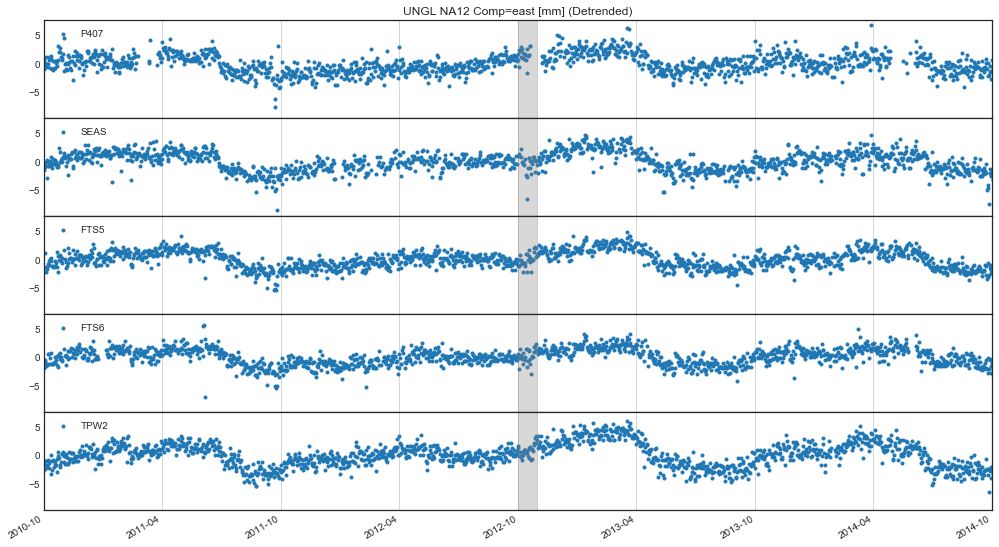

In [36]:
# Same plot, detrend the data
sites = ['P407', 'SEAS', 'FTS5', 'FTS6', 'TPW2']#, 'LWCK', 'IWAC', 'P405'] #<40km 

comp = 'east'
fig,axes = plt.subplots(len(sites),1, sharex=True, sharey=True, figsize=(17,10))
for i,site in enumerate(sites):
    ax = axes[i]
    tenv3 = gps.ungl.download_data(site, refframe, overwrite=False)
    tmp = gps.ungl.load_tenv3(tenv3)
    #tmp = tmp['2010/10/01':'2014/10/01']#specific time range
    tmp = gps.analysis.do_detrend(tmp, comp, start='2010/08/01', end='2016/01/01')
    ax.scatter(tmp.index, tmp['detrend1_'+comp],marker='.',label=site)
    ax.legend(loc='upper left')
    ax.grid(axis='x')

    # Highlight strain increase
    ax.axvspan(pd.to_datetime('2012/10/01'), pd.to_datetime('2012/10/30'), color='gray', alpha=0.3)
    
axes[0].set_title('UNGL NA12 Comp={} [mm] (Detrended)'.format(comp))
fig.subplots_adjust(hspace=0, wspace=0)
fig.autofmt_xdate()

plt.xlim(pd.to_datetime('2010/10/01'), pd.to_datetime('2014/10/01'))#specific time range
#plt.ylim(-10,10)

# Detrend North

P407 already dowloaded... skipping
north Rate [mm/yr]=7191.5235647466125

/Users/scott/Documents/GitHub/gpstools/analysis.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df['ints'] = df.index.asi8
/Users/scott/Documents/GitHub/gpstools/analysis.py:59: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df['elapsed_s'] = (df.ints - df.ints[0])/1e9 #sec
/Users/scott/Documents/GitHub/gpstools/analysis.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/


RMSE =  1.70515921916
SEAS already dowloaded... skipping
north Rate [mm/yr]=7714.104997337683
RMSE =  2.31426510932
FTS5 already dowloaded... skipping
north Rate [mm/yr]=7896.933588220881
RMSE =  1.2907203
FTS6 already dowloaded... skipping
north Rate [mm/yr]=7751.9888279091265
RMSE =  1.29444984779
TPW2 already dowloaded... skipping
north Rate [mm/yr]=6645.350595950775
RMSE =  2.37554712754


(734046.0, 735507.0)

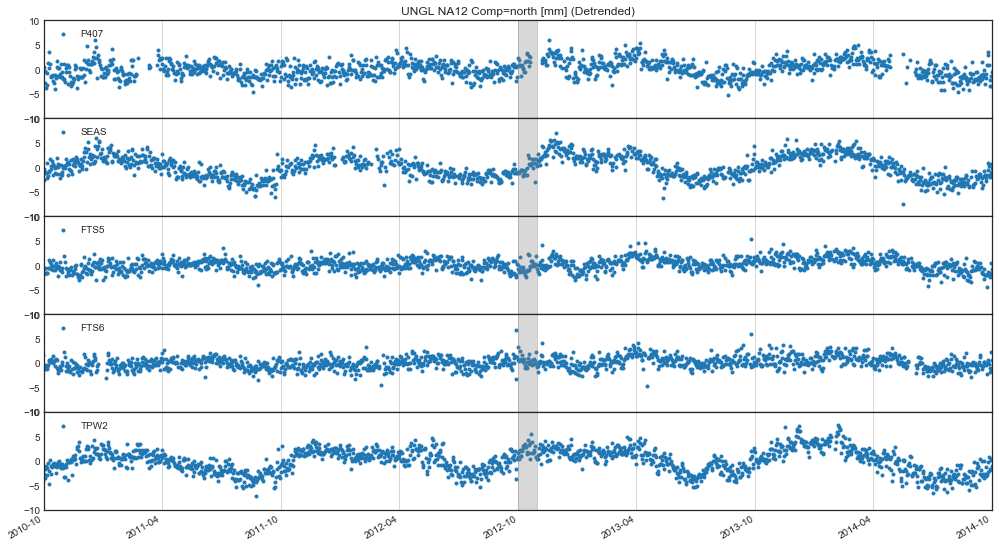

In [43]:
# Same plot, detrend the data
sites = ['P407', 'SEAS', 'FTS5', 'FTS6', 'TPW2']#, 'LWCK', 'IWAC', 'P405'] #<40km 

comp = 'north'
fig,axes = plt.subplots(len(sites),1, sharex=True, sharey=True, figsize=(17,10))
for i,site in enumerate(sites):
    ax = axes[i]
    tenv3 = gps.ungl.download_data(site, refframe, overwrite=False)
    tmp = gps.ungl.load_tenv3(tenv3)
    #tmp = tmp['2010/10/01':'2014/10/01']#specific time range
    tmp = gps.analysis.do_detrend(tmp, comp, start='2010/08/01', end='2016/01/01')
    ax.scatter(tmp.index, tmp['detrend1_'+comp],marker='.',label=site)
    ax.legend(loc='upper left')
    ax.grid(axis='x')
    ax.set_ylim(-10,10)
    # Highlight strain increase
    ax.axvspan(pd.to_datetime('2012/10/01'), pd.to_datetime('2012/10/30'), color='gray', alpha=0.3)
    
axes[0].set_title('UNGL NA12 Comp={} [mm] (Detrended)'.format(comp))
fig.subplots_adjust(hspace=0, wspace=0)
fig.autofmt_xdate()

plt.xlim(pd.to_datetime('2010/10/01'), pd.to_datetime('2014/10/01'))#specific time range
#plt.ylim(-10,10)

In [65]:
# Check data gap at P407:
df.loc['2012/10/10':'2012/11/10'].date

date
2012-10-10    12OCT10
2012-10-11    12OCT11
2012-10-12    12OCT12
2012-10-13    12OCT13
2012-10-14    12OCT14
2012-10-15    12OCT15
2012-10-16    12OCT16
2012-10-17    12OCT17
2012-10-18    12OCT18
2012-10-19    12OCT19
2012-10-20    12OCT20
2012-11-06    12NOV06
2012-11-07    12NOV07
2012-11-08    12NOV08
2012-11-09    12NOV09
2012-11-10    12NOV10
Name: date, dtype: object

# Vertical

P407 already dowloaded... skipping
up Rate [mm/yr]=161.65803083308018

/Users/scott/Documents/GitHub/gpstools/analysis.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df['ints'] = df.index.asi8
/Users/scott/Documents/GitHub/gpstools/analysis.py:59: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df['elapsed_s'] = (df.ints - df.ints[0])/1e9 #sec
/Users/scott/Documents/GitHub/gpstools/analysis.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/


RMSE =  5.73265398981
SEAS already dowloaded... skipping
up Rate [mm/yr]=256.2636671478897
RMSE =  5.54614267086
FTS5 already dowloaded... skipping
up Rate [mm/yr]=241.90583594469214
RMSE =  5.60987605175
FTS6 already dowloaded... skipping
up Rate [mm/yr]=679.7988949915173
RMSE =  5.76598957742
TPW2 already dowloaded... skipping
up Rate [mm/yr]=-101.2718412200503
RMSE =  6.38810967082


(734046.0, 735507.0)

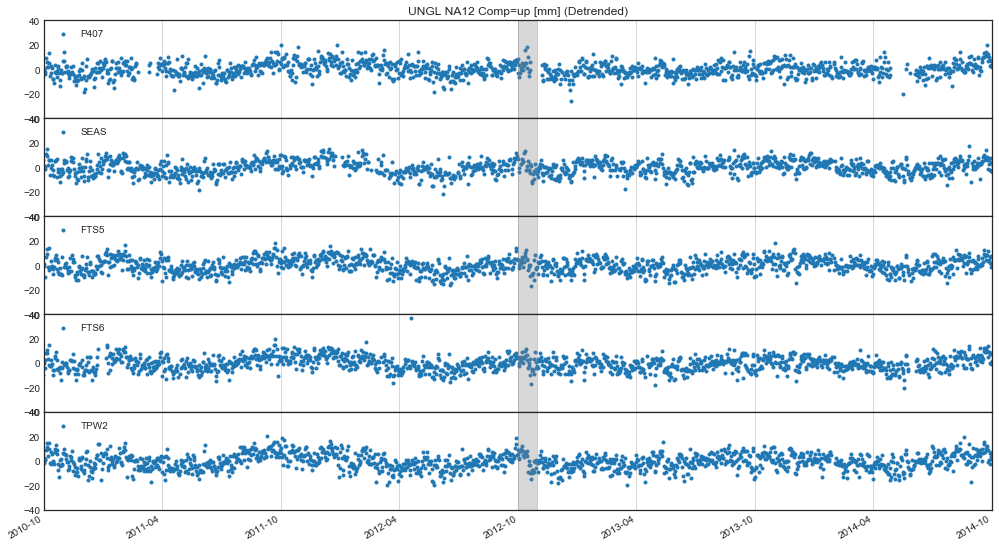

In [42]:
# Same plot, detrend the data
sites = ['P407', 'SEAS', 'FTS5', 'FTS6', 'TPW2']#, 'LWCK', 'IWAC', 'P405'] #<40km 

comp = 'up'
fig,axes = plt.subplots(len(sites),1, sharex=True, sharey=True, figsize=(17,10))
for i,site in enumerate(sites):
    ax = axes[i]
    tenv3 = gps.ungl.download_data(site, refframe, overwrite=False)
    tmp = gps.ungl.load_tenv3(tenv3)
    #tmp = tmp['2010/10/01':'2014/10/01']#specific time range
    tmp = gps.analysis.do_detrend(tmp, comp, start='2010/08/01', end='2016/01/01')
    ax.scatter(tmp.index, tmp['detrend1_'+comp],marker='.',label=site)
    ax.legend(loc='upper left')
    ax.grid(axis='x')
    ax.set_ylim(-40,40)
    # Highlight strain increase
    ax.axvspan(pd.to_datetime('2012/10/01'), pd.to_datetime('2012/10/30'), color='gray', alpha=0.3)
    
axes[0].set_title('UNGL NA12 Comp={} [mm] (Detrended)'.format(comp))
fig.subplots_adjust(hspace=0, wspace=0)
fig.autofmt_xdate()

plt.xlim(pd.to_datetime('2010/10/01'), pd.to_datetime('2014/10/01'))#specific time range


### NOTES

* Possible anomalous northward motion at SEAS (5mm)
* Suspicious datagap at colocated P407 GPS with B022 strainmeter (10/20 to 11/06)
* From station notes B022 in Sea Side, OR, at 10m elevation, installed at 220m depth.

# Check JPL solutions for P407 and SEAS

In [72]:
#station = 'SEAS' #doesn't exist...
station = 'P407'
refframe= 'ITRF2008/IGS08B'
# Reference frame is ITRF2008
# Download data
df = gps.jpl.load_timeseries(station)
titlestr = '{} ({}) [mm]'.format(station, refframe)

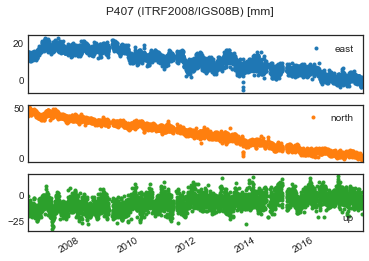

In [73]:
axes = df.plot(y=['east','north','up'], style='.' ,sharex=True, subplots=True, title=titlestr)

/Users/scott/Documents/GitHub/gpstools/analysis.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df['ints'] = df.index.asi8
/Users/scott/Documents/GitHub/gpstools/analysis.py:59: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df['elapsed_s'] = (df.ints - df.ints[0])/1e9 #sec
/Users/scott/Documents/GitHub/gpstools/analysis.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/

north Rate [mm/yr]=-4818.5617398957875
RMSE =  2.15893500659
north Rate [mm/yr]=-5278.241812464406
RMSE =  2.74702287194


(734046.0, 735507.0)

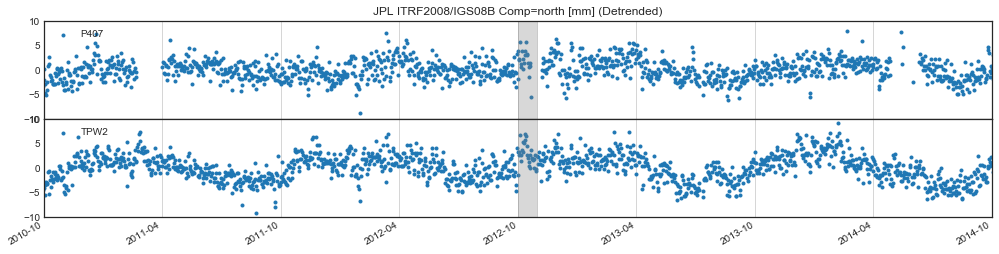

In [77]:
# Same plot, detrend the data
sites = ['P407', 'TPW2']#, 'LWCK', 'IWAC', 'P405'] #<40km 

comp = 'north'
fig,axes = plt.subplots(len(sites),1, sharex=True, sharey=True, figsize=(17,4))
for i,site in enumerate(sites):
    ax = axes[i]
    #tenv3 = gps.jpl.download_data(site, refframe, overwrite=False)
    tmp = gps.jpl.load_timeseries(site)
    #tmp = tmp['2010/10/01':'2014/10/01']#specific time range
    tmp = gps.analysis.do_detrend(tmp, comp, start='2010/08/01', end='2016/01/01')
    ax.scatter(tmp.index, tmp['detrend1_'+comp],marker='.',label=site)
    ax.legend(loc='upper left')
    ax.grid(axis='x')
    ax.set_ylim(-10,10)
    # Highlight strain increase
    ax.axvspan(pd.to_datetime('2012/10/01'), pd.to_datetime('2012/10/30'), color='gray', alpha=0.3)
    
axes[0].set_title('JPL ITRF2008/IGS08B Comp={} [mm] (Detrended)'.format(comp))
fig.subplots_adjust(hspace=0, wspace=0)
fig.autofmt_xdate()

plt.xlim(pd.to_datetime('2010/10/01'), pd.to_datetime('2014/10/01'))#specific time range



# Check PANGA solutions

In [89]:
# We'll use station TPW2
station = 'P407'
refframe= 'ITRF2008'
# Reference frame is ITRF2008
# Download data
gps.panga.download_data(station, overwrite=False)
titlestr = '{} ({}) [mm]'.format(station, refframe)

In [90]:
df = gps.panga.load_panga(station)

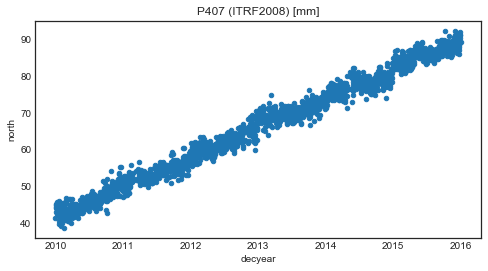

In [91]:
df['2010/01/01':'2015/12/31'].plot.scatter('decyear', 'north', title=titlestr, figsize=(8,4))

/Users/scott/Documents/GitHub/gpstools/panga/data/P407e.csv already dowloaded... skipping
/Users/scott/Documents/GitHub/gpstools/panga/data/P407n.csv already dowloaded... skipping
/Users/scott/Documents/GitHub/gpstools/panga/data/P407u.csv already dowloaded... skipping


/Users/scott/Documents/GitHub/gpstools/analysis.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df['ints'] = df.index.asi8
/Users/scott/Documents/GitHub/gpstools/analysis.py:59: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df['elapsed_s'] = (df.ints - df.ints[0])/1e9 #sec


east Rate [mm/yr]=12680.917325503851
RMSE =  1.51972587279
/Users/scott/Documents/GitHub/gpstools/panga/data/SEASe.csv already dowloaded... skipping
/Users/scott/Documents/GitHub/gpstools/panga/data/SEASn.csv already dowloaded... skipping
/Users/scott/Documents/GitHub/gpstools/panga/data/SEASu.csv already dowloaded... skipping


/Users/scott/Documents/GitHub/gpstools/analysis.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df['linear_{}'.format(col)] = est.predict(X)
/Users/scott/Documents/GitHub/gpstools/analysis.py:71: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df['detrend1_{}'.format(col)] = y - est.predict(X)


east Rate [mm/yr]=10492.539636337819
RMSE =  1.6474876588
/Users/scott/Documents/GitHub/gpstools/panga/data/TPW2e.csv already dowloaded... skipping
/Users/scott/Documents/GitHub/gpstools/panga/data/TPW2n.csv already dowloaded... skipping
/Users/scott/Documents/GitHub/gpstools/panga/data/TPW2u.csv already dowloaded... skipping
east Rate [mm/yr]=9220.349609466291
RMSE =  2.12763590658


(734046.0, 735507.0)

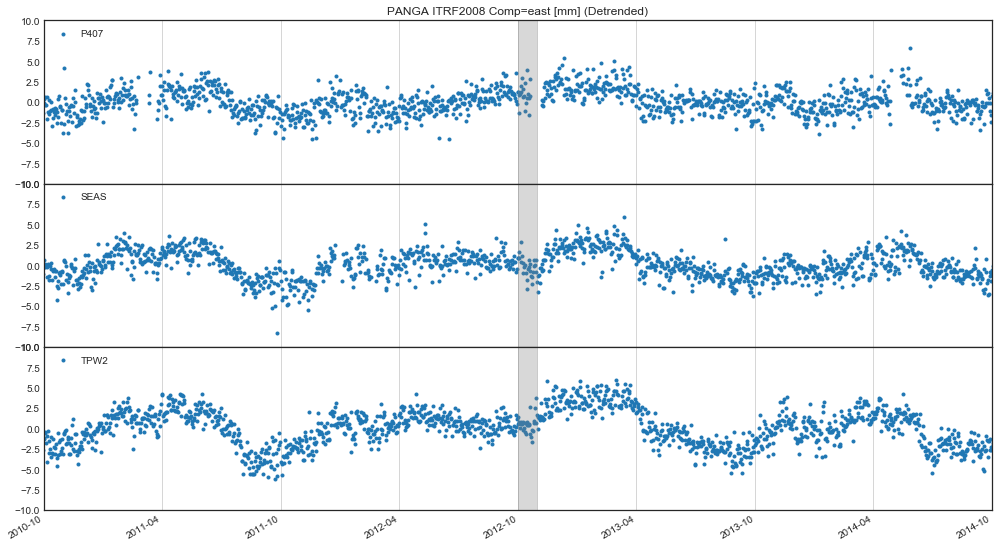

In [125]:
# Same plot, detrend the data
sites = ['P407', 'SEAS',  'TPW2']#, 'LWCK', 'IWAC', 'P405'] #<40km 
#error: 'FTS5', 'FTS6',
comp = 'east'
fig,axes = plt.subplots(len(sites),1, sharex=True, sharey=True, figsize=(17,10))
for i,site in enumerate(sites):
    ax = axes[i]
    tenv3 = gps.panga.download_data(site, overwrite=False)
    tmp = gps.panga.load_panga(site)
    #tmp = tmp['2010/10/01':'2014/10/01']#specific time range
    tmp = tmp.dropna()
    tmp = gps.analysis.do_detrend(tmp, comp, start='2010/08/01', end='2016/01/01')
    ax.scatter(tmp.index, tmp['detrend1_'+comp],marker='.',label=site)
    ax.legend(loc='upper left')
    ax.grid(axis='x')
    ax.set_ylim(-10,10)
    # Highlight strain increase
    ax.axvspan(pd.to_datetime('2012/10/01'), pd.to_datetime('2012/10/30'), color='gray', alpha=0.3)
    
axes[0].set_title('PANGA ITRF2008 Comp={} [mm] (Detrended)'.format(comp))
fig.subplots_adjust(hspace=0, wspace=0)
fig.autofmt_xdate()

plt.xlim(pd.to_datetime('2010/10/01'), pd.to_datetime('2014/10/01'))#specific time range
#plt.ylim(-10,10)

In [107]:
# Plot detrended P407 on subplots for direct comparison
station = 'P407'

# Load PANGA
ref1 = 'ITRF2008'
# Reference frame is ITRF2008
# Download data
gps.panga.download_data(station,overwrite=False)
# Load the timeseries as pandas dataframe
df1 = gps.panga.load_panga(station)
title1 = 'UNGL:  {} ({}) [mm]'.format(station, ref1)

# Load UNGL
ref2= 'NA12'
# Download data
tenv3 = gps.ungl.download_data(station, ref2, overwrite=True)
df2 = gps.ungl.load_tenv3(tenv3)
title2 = 'PANGA:  {} ({}) [mm]'.format(station, ref2)

# Load JPL
ref3= 'ITRF2008/IGS08B'
# Download data
df3 = gps.jpl.load_timeseries(station)
title3 = 'JPL:  {} ({}) [mm]'.format(station, ref3)

/Users/scott/Documents/GitHub/gpstools/panga/data/P407e.csv already dowloaded... skipping
/Users/scott/Documents/GitHub/gpstools/panga/data/P407n.csv already dowloaded... skipping
/Users/scott/Documents/GitHub/gpstools/panga/data/P407u.csv already dowloaded... skipping
Overwriting P407


Rate [mm/yr]=7974.2485859186445
Rate [mm/yr]=7295.260306779646

/Users/scott/Documents/GitHub/gpstools/analysis.py:82: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df['ints'] = df.index.asi8
/Users/scott/Documents/GitHub/gpstools/analysis.py:83: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df['elapsed_s'] = (df.ints - df.ints[0])/1e9 #sec



Rate [mm/yr]=-4820.852152386246


/Users/scott/Documents/GitHub/gpstools/analysis.py:93: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df['linear_fit'] = est.predict(X)
/Users/scott/Documents/GitHub/gpstools/analysis.py:94: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df['detrend'] = y - df.linear_fit


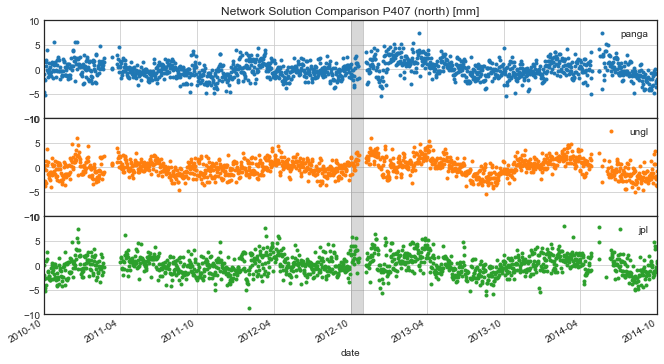

In [116]:
# Subtract mean from component to compare on same plot
#comp = 'east'
comp = 'north'
#comp = 'up'


start = '2010/10/01'
end = '2014/10/01'
# crop to target date range
tmp1 = df1[start:end]#specific time range
tmp2 = df2[start:end]
tmp3 = df3[start:end]


# subtract mean
#pangaData = df1[comp]-df1[comp].mean()
#unglData = df2[comp]-df2[comp].mean()

# linear detrend 
# Ensure no nans in time series
tmp1 = tmp1.dropna()
tmp1 = gps.analysis.detrend(tmp1, comp)
pangaData = tmp1['detrend']
tmp2 = gps.analysis.detrend(tmp2, comp)
unglData = tmp2['detrend']
tmp3 = gps.analysis.detrend(tmp3, comp)
jplData = tmp3['detrend']

df = pd.DataFrame(dict(panga=pangaData)) 
df['ungl'] = unglData
df['jpl'] = jplData  

axes = df.plot(subplots=True, style='.', figsize=(11,6), sharex=True, sharey=True)
plt.subplots_adjust(hspace=0, wspace=0)
for ax in axes:
    ax.grid()
    ax.set_ylim(-10, 10) #North
    ax.axvspan(pd.to_datetime('2012/10/01'), pd.to_datetime('2012/10/30'), color='gray', alpha=0.3)
    
axes[0].set_title('Network Solution Comparison {} ({}) [mm]'.format(station,comp))
#print(df.describe())

In [119]:
# Compare SEAS Solutions (Panga & UNGL (JPL didn't process...))
# Plot detrended P407 on subplots for direct comparison
station = 'SEAS'

# Load PANGA
ref1 = 'ITRF2008'
# Reference frame is ITRF2008
# Download data
gps.panga.download_data(station,overwrite=False)
# Load the timeseries as pandas dataframe
df1 = gps.panga.load_panga(station)
title1 = 'UNGL:  {} ({}) [mm]'.format(station, ref1)

# Load UNGL
ref2= 'NA12'
# Download data
tenv3 = gps.ungl.download_data(station, ref2, overwrite=True)
df2 = gps.ungl.load_tenv3(tenv3)
title2 = 'PANGA:  {} ({}) [mm]'.format(station, ref2)

/Users/scott/Documents/GitHub/gpstools/panga/data/SEASe.csv already dowloaded... skipping
/Users/scott/Documents/GitHub/gpstools/panga/data/SEASn.csv already dowloaded... skipping
/Users/scott/Documents/GitHub/gpstools/panga/data/SEASu.csv already dowloaded... skipping
Overwriting SEAS


Rate [mm/yr]=1903.041204740722


/Users/scott/Documents/GitHub/gpstools/analysis.py:82: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df['ints'] = df.index.asi8
/Users/scott/Documents/GitHub/gpstools/analysis.py:83: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df['elapsed_s'] = (df.ints - df.ints[0])/1e9 #sec


Rate [mm/yr]=579.3197141036331


/Users/scott/Documents/GitHub/gpstools/analysis.py:93: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df['linear_fit'] = est.predict(X)
/Users/scott/Documents/GitHub/gpstools/analysis.py:94: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df['detrend'] = y - df.linear_fit


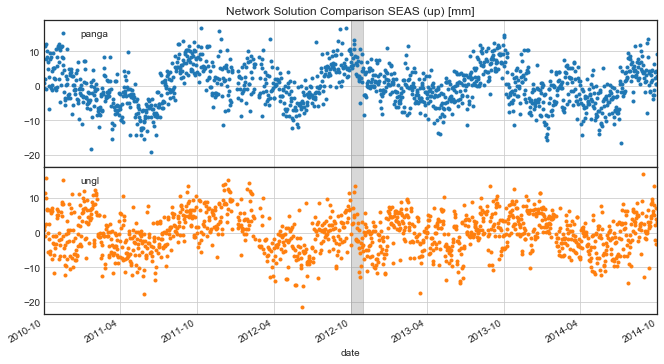

In [126]:
# Subtract mean from component to compare on same plot
#comp = 'east'
#comp = 'north'
comp = 'up'


start = '2010/10/01'
end = '2014/10/01'
# crop to target date range
tmp1 = df1[start:end]#specific time range
tmp2 = df2[start:end]
#tmp3 = df3[start:end]


# subtract mean
#pangaData = df1[comp]-df1[comp].mean()
#unglData = df2[comp]-df2[comp].mean()

# linear detrend 
# Ensure no nans in time series
tmp1 = tmp1.dropna()
tmp1 = gps.analysis.detrend(tmp1, comp)
pangaData = tmp1['detrend']
tmp2 = gps.analysis.detrend(tmp2, comp)
unglData = tmp2['detrend']
#tmp3 = gps.analysis.detrend(tmp3, comp)
#jplData = tmp3['detrend']

df = pd.DataFrame(dict(panga=pangaData)) 
df['ungl'] = unglData
#df['jpl'] = jplData  

axes = df.plot(subplots=True, style='.', figsize=(11,6), sharex=True, sharey=True)
plt.subplots_adjust(hspace=0, wspace=0)
for ax in axes:
    ax.grid()
    #ax.set_ylim(-10, 10) #North
    ax.axvspan(pd.to_datetime('2012/10/01'), pd.to_datetime('2012/10/30'), color='gray', alpha=0.3)
    
axes[0].set_title('Network Solution Comparison {} ({}) [mm]'.format(station,comp))
#print(df.describe())

# Vector Map

In [322]:
# Find other GPS stations in the vicinity
dfS = gps.ungl.load_stations()
pad = 1 #degree
minlat = 45
maxlat = 48
minlon = -124.5
maxlon = -122.4
subset = dfS.query('(@minlat < lat < @maxlat) and (@minlon < lon < @maxlon)')

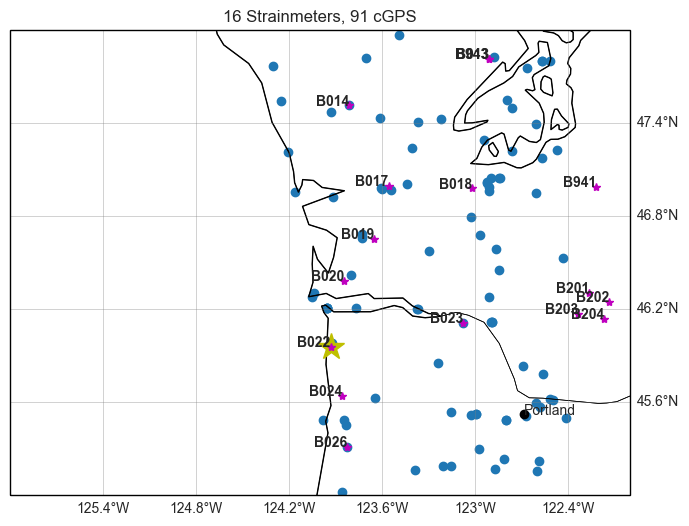

In [323]:
# NOTE: cartopy is smart enough to figure out lon -127 or 227 converntions
plot_CRS = ccrs.PlateCarree()
geodetic_CRS = ccrs.Geodetic()

# frame station by box of several degrees
frame=5 #degrees
x0, y0 = plot_CRS.transform_point(-126, 45, geodetic_CRS)
x1, y1 = plot_CRS.transform_point(-122, 48, geodetic_CRS)

fig,ax = plt.subplots(figsize=(8,8), dpi=100, 
                      subplot_kw=dict(projection=plot_CRS))

ax.set_xlim((x0, x1))
ax.set_ylim((y0, y1))

#ax.stock_img() # very low-res, but fast!
ax.coastlines(resolution='50m') #10m is highest res

states = cfeature.NaturalEarthFeature(scale='50m',
                                 category='cultural',
                                 name='admin_1_states_provinces_lakes')
ax.add_feature(states, facecolor='none', edgecolor='k',linewidth=0.5)

gl = ax.gridlines(ccrs.PlateCarree(), draw_labels=True,
                  linewidth=0.5, color='gray', alpha=0.5, linestyle='-')
gl.xlabels_top = False
gl.ylabels_left = False
#gl.xlines = False
#gl.xlocator = mticker.FixedLocator([-180, -45, 0, 45, 180])
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER


# Add a few cities
ax.plot(-122.681944, 45.52, 'ko', transform=ccrs.Geodetic())
ax.text(-122.681944, 45.52, 'Portland', transform=ccrs.Geodetic())

# Add GPS
ax.scatter(subset.lon, subset.lat,  transform=ccrs.Geodetic())
#for i in range(len(subset)):
#    ax.text(subset.lon.iloc[i], subset.lat.iloc[i], subset.site.iloc[i], transform=ccrs.Geodetic())

ax.plot(B022.lon, B022.lat, 'y*', ms=20, transform=ccrs.Geodetic())
#ax.text(B022.lon, B022.lat, 'B022', fontweight='bold', transform=ccrs.Geodetic())

# Addstrain meters
for i,row in dfStrain.iterrows():
    ax.plot(row.lon, row.lat, 'm*', transform=ccrs.Geodetic())
    ax.text(row.lon, row.lat, row.id, fontweight='bold', ha='right', transform=ccrs.Geodetic())

plt.title('{} Strainmeters, {} cGPS'.format(len(dfStrain), len(subset)))

In [70]:
# Add linear fit velocity data to station subset dataframe
def fit_linear(x,y):
    z,cov = np.polyfit(x, y, 1, cov=True)
    p = np.poly1d(z)
    #print(p)
    stderr = 2*np.sqrt(np.diag(cov))
    #print('{}: {:.2f} +/- {:.2f} mm/yr'.format(comp, z[0], stderr[0]))
    residuals = (p(x) - y)
    rmse = np.sqrt((np.sum(residuals**2) / residuals.size))
    #print('rmse = {:.2f}'.format(rmse))
    
    return z[0]

In [324]:
# Get linear rate over specific time range
# Same plot, detrend the data

for i,site in subset.site.iteritems():
    gps.panga.download_data(site, overwrite=False)
    
    tmp = gps.panga.load_panga(site)
    if tmp is not None:
        tmp = tmp['2010/10/01':'2014/10/01']#specific time range
        tmp = tmp.dropna()

        records = len(tmp)
        print(site, '{} records'.format(records))
        #subset.set_value(i, 'ndays', records)
        subset.loc[i, 'ndays'] = records #probably a way to speed this up...
        
        # Check for at least one year of daily solutions, don't care when or if continuous
        if records > 365: 
            rate = fit_linear(tmp.decyear, tmp.east)
            #subset.set_value(i, 'east', rate)
            subset.loc[i, 'east'] = rate
            rate = fit_linear(tmp.decyear, tmp.north)
            #subset.set_value(i, 'north', rate)
            subset.loc[i, 'north'] = rate
            rate = fit_linear(tmp.decyear, tmp.up)
            #subset.set_value(i, 'up', rate)
            subset.loc[i, 'up'] = rate


BILS 982 records

/Users/scott/miniconda3/envs/forge2017/lib/python3.6/site-packages/pandas/core/indexing.py:337: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/Users/scott/miniconda3/envs/forge2017/lib/python3.6/site-packages/pandas/core/indexing.py:517: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s



BTON 0 records
CATH 1407 records
CHZZ 1460 records
No timeseries data for COB1
CROK 1388 records
CUSH 1338 records
CVO1 1418 records
DEEJ 648 records
ELSR 1406 records
ESM1 525 records
FTS1 0 records
No timeseries data for FTS2
No timeseries data for FTS5
No timeseries data for FTS6
GRMD 1404 records
HGP1 178 records
IWAC 398 records
JIME 1144 records
KELS 0 records
KTBW 1452 records
LNGB 1428 records
LWCK 829 records
No timeseries data for MON3
NWBG 1270 records
OCEN 1284 records
OLAR 616 records
OLMP 1022 records
No timeseries data for ORDO
No timeseries data for ORGR
No timeseries data for ORHI
No timeseries data for ORMO
No timeseries data for ORMV
No timeseries data for ORPO
No timeseries data for ORTI
P064 1262 records
P395 1460 records
P396 1455 records
P397 1457 records
P398 1458 records
P399 1325 records
P400 1459 records
P402 1457 records
P404 1458 records
P405 1460 records
P406 1459 records
P407 1395 records
P408 1434 records
P409 1460 records
P410 1455 records
P411 1459 re

In [431]:
subset.head()
#subset.east.describe()

count    61.000000
mean      7.670147
std       2.526666
min       4.337609
25%       5.832912
50%       6.883895
75%       8.469400
max      15.594589
Name: east, dtype: float64

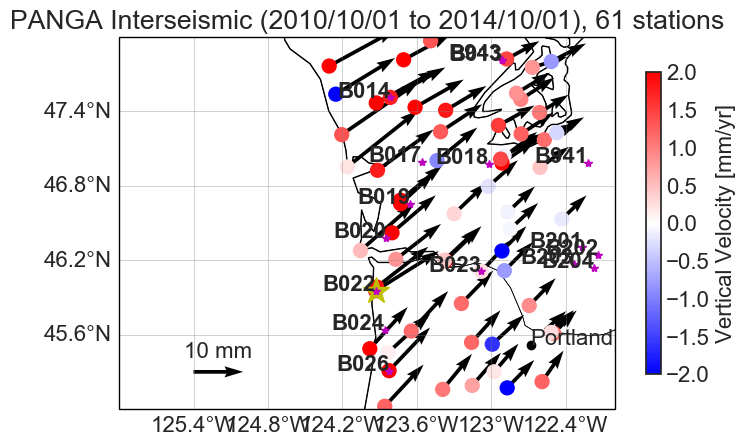

In [446]:
#NOTE: add scale arrow!!!

# Same map with quiver vectors
# NOTE: cartopy is smart enough to figure out lon -127 or 227 converntions
plot_CRS = ccrs.PlateCarree()
geodetic_CRS = ccrs.Geodetic()

# frame station by box of several degrees
frame=5 #degrees
x0, y0 = plot_CRS.transform_point(-126, 45, geodetic_CRS)
x1, y1 = plot_CRS.transform_point(-122, 48, geodetic_CRS)

fig,ax = plt.subplots(figsize=(8,8), dpi=100, 
                      subplot_kw=dict(projection=plot_CRS))

ax.set_xlim((x0, x1))
ax.set_ylim((y0, y1))

#ax.stock_img() # very low-res, but fast!
ax.coastlines(resolution='50m') #10m is highest res

states = cfeature.NaturalEarthFeature(scale='50m',
                                 category='cultural',
                                 name='admin_1_states_provinces_lakes')
ax.add_feature(states, facecolor='none', edgecolor='k',linewidth=0.5)

gl = ax.gridlines(ccrs.PlateCarree(), draw_labels=True,
                  linewidth=0.5, color='gray', alpha=0.5, linestyle='-')
gl.xlabels_top = False
gl.ylabels_right = False
gl.ylabels_left = True
#gl.xlines = False
#gl.xlocator = mticker.FixedLocator([-180, -45, 0, 45, 180])
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER


# Add a few cities
ax.plot(-122.681944, 45.52, 'ko', transform=ccrs.Geodetic())
ax.text(-122.681944, 45.52, 'Portland', transform=ccrs.Geodetic())

# Add GPS Vectors
#ax.scatter(subset.lon, subset.lat,  transform=ccrs.Geodetic())
#for i in range(len(subset)):
#    ax.text(subset.lon.iloc[i], subset.lat.iloc[i], subset.site.iloc[i], transform=ccrs.Geodetic())
sc = plt.scatter(subset.lon, subset.lat, c=subset.up, s=100, 
                 norm=None,
                 vmin=-2,
                 vmax=2,
                 cmap=plt.cm.bwr, 
                 #cmap=plt.cm.Blues_r, 
                 #transform=ccrs.Geodetic(),
                 zorder=2,
                 )

Q = plt.quiver(subset.lon, subset.lat, subset.east, subset.north, scale=100, color='k', zorder=1) 

ax.plot(B022.lon, B022.lat, 'y*', ms=20, transform=ccrs.Geodetic())
#ax.text(B022.lon, B022.lat, 'B022', fontweight='bold', transform=ccrs.Geodetic())

qk = plt.quiverkey(Q, 0.2, 0.1, 10, '10 mm', 
                   labelpos='N',
                   coordinates='axes')

# Addstrain meters
for i,row in dfStrain.iterrows():
    ax.plot(row.lon, row.lat, 'm*', transform=ccrs.Geodetic())
    ax.text(row.lon, row.lat, row.id, fontweight='bold', ha='right', transform=ccrs.Geodetic())

    
cb = plt.colorbar(sc, shrink=0.5)
cb.set_label('Vertical Velocity [mm/yr]')
plt.title('PANGA Interseismic (2010/10/01 to 2014/10/01), {} stations'.format(len(subset.dropna())))

In [423]:
# Plot vectors for time periods before and after strain meter transient (with linear interseismic removed)
# Get linear rate over specific time range
# Same plot, detrend the data
subset = subset.dropna() #Don't bother downloading and loading stations we know don't work!

# Immediately before and after strain transient at B2022
#start1 = '2012/10/01'
#end1 = '2012/10/11'
#start2 = '2012/10/20'
#end2 = '2012/10/30'

# Month of November (after 2012 slow slip event, capturing interseismic rebound)
start1 = '2012/10/16'
end1 = '2012/10/30'
#start1 = '2012/11/01'
#end1 = '2012/11/15'
start2 = '2012/11/16'
end2 = '2012/11/30'

# Actual Slow slip event
start1 = '2012/08/16'
end1 = '2012/08/30'
start2 = '2012/10/16'
end2 = '2012/10/30'


for i,site in subset.site.iteritems():
    print(site)
    gps.panga.download_data(site, overwrite=False)
    
    tmp = gps.panga.load_panga(site)    
    if tmp is not None:
        # Crop to 4 year span
        tmp = tmp['2010/10/01':'2014/10/01']#specific time range
        tmp = tmp.dropna()
        
        if len(tmp) > 365: 
            tmp = gps.analysis.fit_linear(tmp)
            tmp['detrend_east'] = tmp.east - tmp.fit_east
            tmp['detrend_north'] = tmp.north - tmp.fit_north
            tmp['detrend_up'] = tmp.up - tmp.fit_up

            before = tmp[start1:end1]
            after = tmp[start2:end2]

            subset.loc[i, 'nB'] = len(before)
            subset.loc[i, 'eastB'] = before.detrend_east.mean()
            subset.loc[i, 'northB'] = before.detrend_north.mean()
            subset.loc[i, 'upB'] = before.detrend_up.mean()
            subset.loc[i, 'eastBsig'] = before.detrend_east.std()
            subset.loc[i, 'northBsig'] = before.detrend_north.std()
            subset.loc[i, 'upBsig'] = before.detrend_up.std()

            subset.loc[i, 'nA'] = len(after)
            subset.loc[i, 'eastA'] = after.detrend_east.mean()
            subset.loc[i, 'northA'] = after.detrend_north.mean()
            subset.loc[i, 'upA'] = after.detrend_up.mean()
            subset.loc[i, 'eastAsig'] = after.detrend_east.std()
            subset.loc[i, 'northAsig'] = after.detrend_north.std()
            subset.loc[i, 'upAsig'] = after.detrend_up.std()

BILS
CATH
CHZZ
CROK
CVO1
DEEJ
ELSR
GRMD
JIME
KTBW
LNGB
LWCK
NWBG
OCEN
OLMP
P064
P395
P396
P397
P398
P399
P400
P402
P404
P405
P406
P407
P408
P409
P410
P411
P412
P414
P415
P417
P418
P419
P420
P421
P423
P424
P425
P426
P430
P446
PABH
PCOL
PDXA
PRDY
RYMD
SC03
SEAS
TACO
TILL
TPW2
TUMW
TWHL
UFDA
VCWA
WDBN
YELM


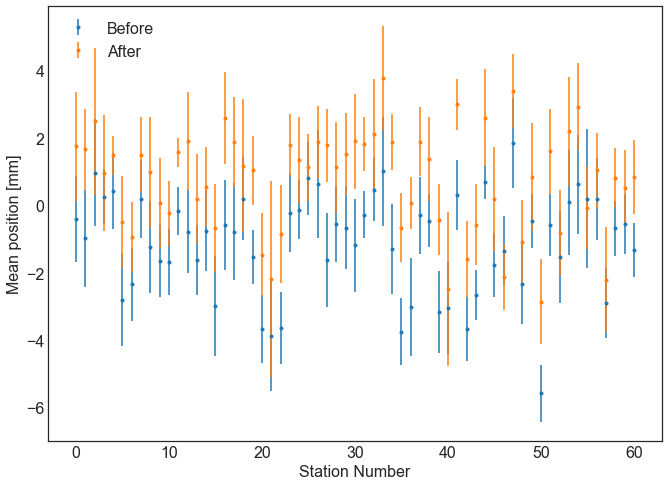

In [382]:
x = np.arange(len(subset))
plt.figure(figsize=(11,8))
plt.errorbar(x, subset.eastB, subset.eastBsig, fmt='.', label='Before')
plt.errorbar(x, subset.eastA, subset.eastAsig, fmt='.',label='After')
plt.legend(loc='upper left')
plt.ylabel('Mean position [mm]')
plt.xlabel('Station Number')

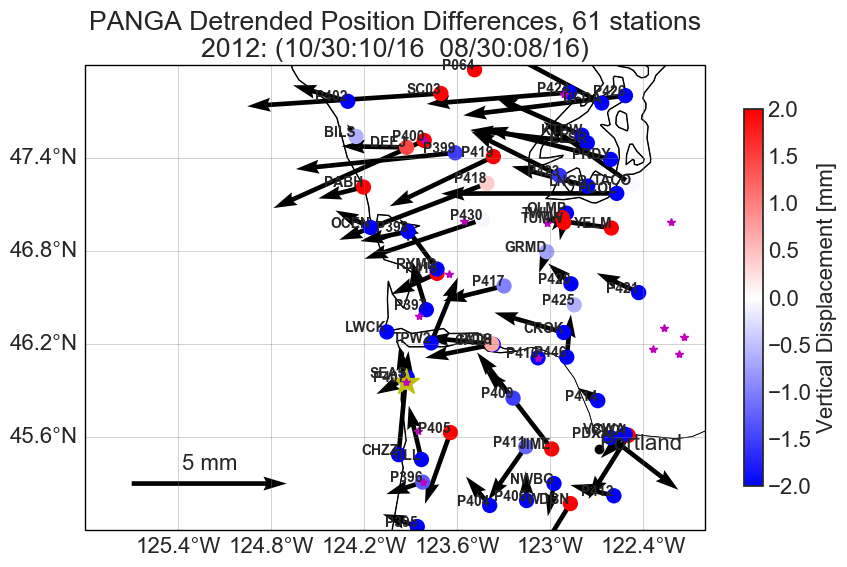

In [444]:
# Same map with quiver vectors
# NOTE: cartopy is smart enough to figure out lon -127 or 227 converntions
plot_CRS = ccrs.PlateCarree()
geodetic_CRS = ccrs.Geodetic()

# frame station by box of several degrees
frame=5 #degrees
x0, y0 = plot_CRS.transform_point(-126, 45, geodetic_CRS)
x1, y1 = plot_CRS.transform_point(-122, 48, geodetic_CRS)

fig,ax = plt.subplots(figsize=(10,10), dpi=100, 
                      subplot_kw=dict(projection=plot_CRS))

ax.set_xlim((x0, x1))
ax.set_ylim((y0, y1))

#ax.stock_img() # very low-res, but fast!
ax.coastlines(resolution='50m') #10m is highest res

states = cfeature.NaturalEarthFeature(scale='50m',
                                 category='cultural',
                                 name='admin_1_states_provinces_lakes')
ax.add_feature(states, facecolor='none', edgecolor='k',linewidth=0.5)

gl = ax.gridlines(ccrs.PlateCarree(), draw_labels=True,
                  linewidth=0.5, color='gray', alpha=0.5, linestyle='-')
gl.xlabels_top = False
gl.ylabels_right = False
gl.ylabels_left = True
#gl.xlines = False
#gl.xlocator = mticker.FixedLocator([-180, -45, 0, 45, 180])
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER


# Add a few cities
ax.plot(-122.681944, 45.52, 'ko', transform=ccrs.Geodetic())
ax.text(-122.681944, 45.52, 'Portland', transform=ccrs.Geodetic())

# Add GPS Vectors
#ax.scatter(subset.lon, subset.lat,  transform=ccrs.Geodetic())
for i in range(len(subset)):
    ax.text(subset.lon.iloc[i], subset.lat.iloc[i], subset.site.iloc[i], 
            fontsize=10, ha='right', fontweight='bold', transform=ccrs.Geodetic())
    
sc = plt.scatter(subset.lon, subset.lat, c=(subset.upA - subset.upB) , s=100, 
                 norm=None,
                 vmin=-2,
                 vmax=2,
                 cmap=plt.cm.bwr, 
                 #cmap=plt.cm.Blues_r, 
                 #transform=ccrs.Geodetic(),
                 zorder=2,
                 )

Q = plt.quiver(subset.lon, subset.lat, (subset.eastA - subset.eastB), (subset.northA - subset.northB), scale=20, color='k', zorder=1) 

ax.plot(B022.lon, B022.lat, 'y*', ms=20, transform=ccrs.Geodetic())
#ax.text(B022.lon, B022.lat, 'B022', fontweight='bold', transform=ccrs.Geodetic())

# Addstrain meters
for i,row in dfStrain.iterrows():
    ax.plot(row.lon, row.lat, 'm*', transform=ccrs.Geodetic())
    #ax.text(row.lon, row.lat, row.id, fontweight='bold', ha='right', transform=ccrs.Geodetic())

qk = plt.quiverkey(Q, 0.2, 0.1, 5, '5 mm', 
                   labelpos='N',
                   coordinates='axes')
    
cb = plt.colorbar(sc, shrink=0.5)
cb.set_label('Vertical Displacement [mm]')
#plt.title('PANGA Detrended Position Differences, {} stations\n2012: (10/20:10/31  10/01:10/10)'.format(len(subset.dropna())))
#plt.title('PANGA Detrended Position Differences, {} stations\n2012: (11/30:11/16  11/01:11/15)'.format(len(subset.dropna())))
#plt.title('PANGA Detrended Position Differences, {} stations\n2012: (11/30:11/16  10/30:10/16)'.format(len(subset.dropna())))
plt.title('PANGA Detrended Position Differences, {} stations\n2012: (10/30:10/16  08/30:08/16)'.format(len(subset.dropna())))

In [425]:
station = 'P418'
s = subset.query('site == @station')

print(s.northB.values, s.northA.values)
print(s.northA.values - s.northB.values)

[ 0.46857626] [-1.35267339]
[-1.82124965]


In [426]:
# Plot detrended SEAS time series with averages

tmp = gps.panga.load_panga(station)    
tmp = tmp['2010/10/01':'2014/10/01']#specific time range
tmp = tmp.dropna()
tmp = gps.analysis.fit_linear(tmp)
tmp['detrend_east'] = tmp.east - tmp.fit_east
tmp['detrend_north'] = tmp.north - tmp.fit_north
tmp['detrend_up'] = tmp.up - tmp.fit_up

# Include 2012 Slow-slip event timing
startss = '2012/08/19'
endss = '2012/10/19'

mid1 = '2012/10/06'
mid2 = '2012/10/26'

mid1 = '2012/11/09'
mid2 = '2012/11/22'

mid1 = '2012/10/23'
mid2 = '2012/11/23'

mid1 = '2012/08/23'
mid2 = '2012/10/23'

(-8, 8)

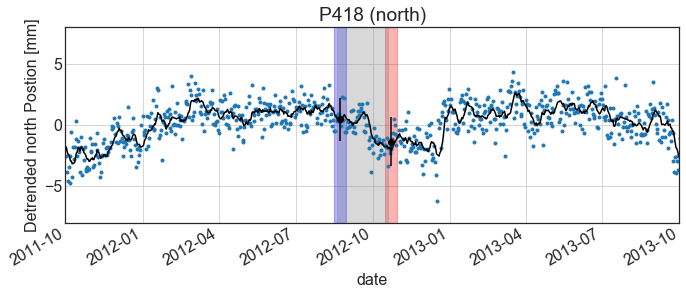

In [427]:
comp = 'north'
roll = tmp['detrend_'+comp].rolling('10d').mean() #10day rolling mean

axes = tmp['detrend_'+comp].plot(subplots=True, style='.', figsize=(11,4), sharex=True, sharey=True)
plt.subplots_adjust(hspace=0, wspace=0)
for ax in axes:
    ax.grid()
    ax.axvspan(pd.to_datetime(start1), pd.to_datetime(end1), color='blue', alpha=0.3)
    ax.axvspan(pd.to_datetime(start2), pd.to_datetime(end2), color='red', alpha=0.3)
    ax.axvspan(pd.to_datetime(startss), pd.to_datetime(endss), color='gray', alpha=0.3)
    ax.plot(roll.index, roll.values, 'k-', label='10day rolling')
    ax.errorbar(pd.to_datetime(mid1), s[comp + 'B'], s[comp+'Bsig']*2, fmt='ko',zorder=10)
    ax.errorbar(pd.to_datetime(mid2), s[comp + 'A'], s[comp+'Asig']*2, fmt='ko',zorder=10 )
    #ax.legend('upper left')
    
plt.xlim(pd.to_datetime('2011/10/01'), pd.to_datetime('2013/10/01'))
plt.ylabel('Detrended {} Postion [mm]'.format(comp))
plt.title('{} ({})'.format(station, comp))

plt.ylim(-8,8)

(-8, 8)

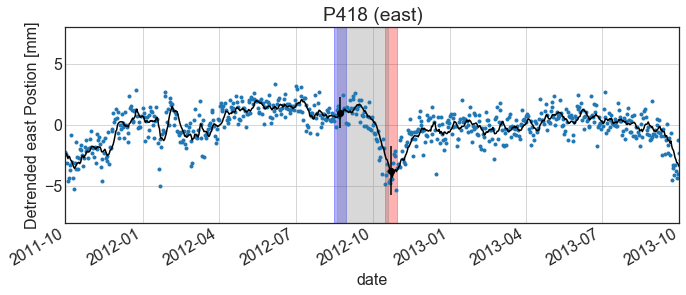

In [428]:
comp = 'east'
roll = tmp['detrend_'+comp].rolling('10d').mean() #10day rolling mean

axes = tmp['detrend_'+comp].plot(subplots=True, style='.', figsize=(11,4), sharex=True, sharey=True)
plt.subplots_adjust(hspace=0, wspace=0)
for ax in axes:
    ax.grid()
    ax.axvspan(pd.to_datetime(start1), pd.to_datetime(end1), color='blue', alpha=0.3)
    ax.axvspan(pd.to_datetime(start2), pd.to_datetime(end2), color='red', alpha=0.3)
    ax.axvspan(pd.to_datetime(startss), pd.to_datetime(endss), color='gray', alpha=0.3)
    ax.plot(roll.index, roll.values, 'k-', label='10day rolling')
    ax.errorbar(pd.to_datetime(mid1), s[comp + 'B'], s[comp+'Bsig']*2, fmt='ko',zorder=10)
    ax.errorbar(pd.to_datetime(mid2), s[comp + 'A'], s[comp+'Asig']*2, fmt='ko',zorder=10 )
    #ax.legend('upper left')
    
plt.xlim(pd.to_datetime('2011/10/01'), pd.to_datetime('2013/10/01'))
plt.ylabel('Detrended {} Postion [mm]'.format(comp))
plt.title('{} ({})'.format(station, comp))

plt.ylim(-8,8)

(-25, 25)

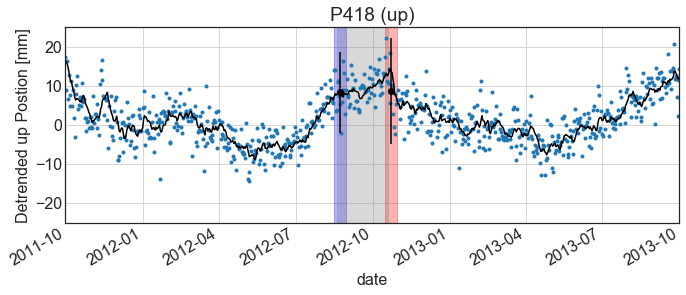

In [429]:
comp = 'up'
roll = tmp['detrend_'+comp].rolling('10d').mean() #10day rolling mean

axes = tmp['detrend_'+comp].plot(subplots=True, style='.', figsize=(11,4), sharex=True, sharey=True)
plt.subplots_adjust(hspace=0, wspace=0)
for ax in axes:
    ax.grid()
    ax.axvspan(pd.to_datetime(start1), pd.to_datetime(end1), color='blue', alpha=0.3)
    ax.axvspan(pd.to_datetime(start2), pd.to_datetime(end2), color='red', alpha=0.3)
    ax.axvspan(pd.to_datetime(startss), pd.to_datetime(endss), color='gray', alpha=0.3)
    ax.plot(roll.index, roll.values, 'k-', label='10day rolling')
    ax.errorbar(pd.to_datetime(mid1), s[comp + 'B'], s[comp+'Bsig']*2, fmt='ko',zorder=10)
    ax.errorbar(pd.to_datetime(mid2), s[comp + 'A'], s[comp+'Asig']*2, fmt='ko',zorder=10 )
    #ax.legend('upper left')
    
plt.xlim(pd.to_datetime('2011/10/01'), pd.to_datetime('2013/10/01'))
plt.ylabel('Detrended {} Postion [mm]'.format(comp))
plt.title('{} ({})'.format(station, comp))

plt.ylim(-25,25)

P064


/Users/scott/Documents/GitHub/gpstools/analysis.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df['ints'] = df.index.asi8
/Users/scott/Documents/GitHub/gpstools/analysis.py:59: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df['elapsed_s'] = (df.ints - df.ints[0])/1e9 #sec


east Rate [mm/yr]=7.997421991222857
RMSE =  1.97589918331
P419


/Users/scott/Documents/GitHub/gpstools/analysis.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df['linear_{}'.format(col)] = est.predict(X)
/Users/scott/Documents/GitHub/gpstools/analysis.py:71: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df['detrend1_{}'.format(col)] = y - est.predict(X)


east Rate [mm/yr]=8.06738638768907
RMSE =  1.63710395112
P418
east Rate [mm/yr]=7.997376622601154
RMSE =  1.78088342313
P430
east Rate [mm/yr]=8.006562432972592
RMSE =  1.77213295992
P417
east Rate [mm/yr]=6.523612410038748
RMSE =  1.49125502765
P408
east Rate [mm/yr]=6.807978807029469
RMSE =  1.43270792613
P409
east Rate [mm/yr]=6.453972163406251
RMSE =  1.22586566786
P411
east Rate [mm/yr]=5.856077187980837
RMSE =  1.42517732246
P406
east Rate [mm/yr]=5.5896813550086994
RMSE =  1.30206773212


(734046.0, 735507.0)

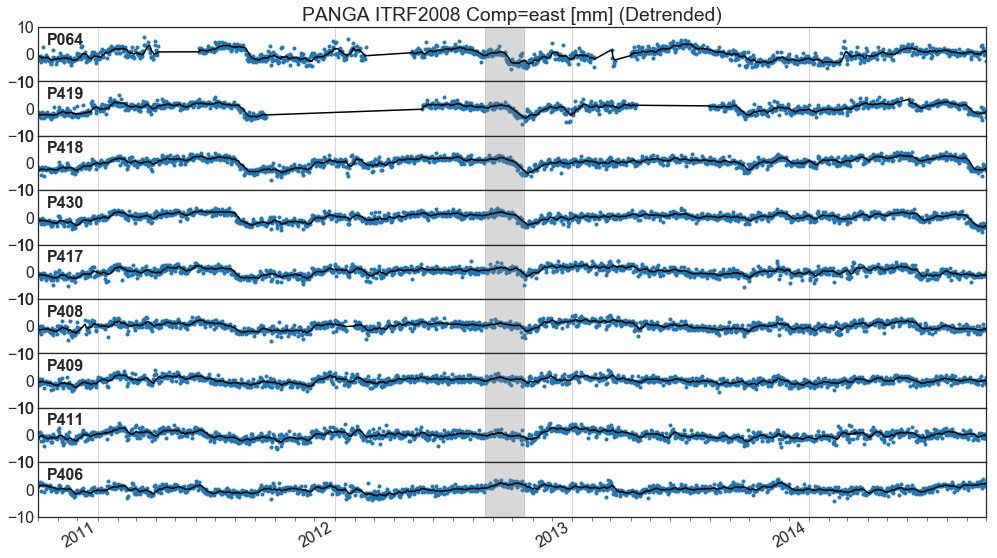

In [361]:
# N-S profile of GPS stations that should show ETS event

sites = ['P064', 'P419', 'P418', 'P430', 'P417', 'P408', 'P409', 'P411', 'P406']

comp = 'east'
fig,axes = plt.subplots(len(sites),1, sharex=True, sharey=True, figsize=(17,10))
for i,site in enumerate(sites):
    print(site)
    ax = axes[i]
    #tenv3 = gps.panga.download_data(site, overwrite=False)
    tmp = gps.panga.load_panga(site)
    #tmp = tmp['2010/10/01':'2014/10/01']#specific time range
    tmp = tmp.dropna()
    tmp = gps.analysis.do_detrend(tmp, comp, start='2010/08/01', end='2016/01/01')
    roll = tmp['detrend1_'+comp].rolling('10d').mean() #10day rolling mean
    ax.plot(roll.index, roll.values, 'k-')
    ax.scatter(tmp.index, tmp['detrend1_'+comp],marker='.',label=site)
    #ax.legend(loc='upper left', prop=dict(weight='bold'))
    ax.grid(axis='x')
    ax.set_ylim(-10,10)
    # Highlight strain increase
    #ax.axvspan(pd.to_datetime('2012/10/01'), pd.to_datetime('2012/10/30'), color='gray', alpha=0.3)
    ax.axvspan(pd.to_datetime(startss), pd.to_datetime(endss), color='gray', alpha=0.3)
    #ax.axvspan(pd.to_datetime(start1), pd.to_datetime(end1), color='blue', alpha=0.3)
    #ax.axvspan(pd.to_datetime(start2), pd.to_datetime(end2), color='red', alpha=0.3)
    ax.text(0.01, 0.9, site, fontsize=16, fontweight='extra bold', ha='left', va='top', transform=ax.transAxes)

months = pltdate.MonthLocator()
years = pltdate.YearLocator()
ax.xaxis.set_major_locator(years)
ax.xaxis.set_minor_locator(months) #too much
ax.fmt_xdata = pltdate.DateFormatter('%Y-%m-%d')

axes[0].set_title('PANGA ITRF2008 Comp={} [mm] (Detrended)'.format(comp))
fig.subplots_adjust(hspace=0, wspace=0)
fig.autofmt_xdate()

plt.tick_params(axis='x', which='minor', bottom=True, length=4)

plt.xlim(pd.to_datetime('2010/10/01'), pd.to_datetime('2014/10/01'))#specific time range
#plt.ylim(-10,10)


P064


/Users/scott/Documents/GitHub/gpstools/analysis.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df['ints'] = df.index.asi8
/Users/scott/Documents/GitHub/gpstools/analysis.py:59: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df['elapsed_s'] = (df.ints - df.ints[0])/1e9 #sec


north Rate [mm/yr]=4.848200804794529
RMSE =  2.92645193987
P419


/Users/scott/Documents/GitHub/gpstools/analysis.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df['linear_{}'.format(col)] = est.predict(X)
/Users/scott/Documents/GitHub/gpstools/analysis.py:71: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df['detrend1_{}'.format(col)] = y - est.predict(X)


north Rate [mm/yr]=5.117367326665031
RMSE =  1.72810961522
P418
north Rate [mm/yr]=5.643927172278195
RMSE =  1.67403159663
P430
north Rate [mm/yr]=6.289631811511996
RMSE =  1.94462904389
P417
north Rate [mm/yr]=6.422225336420771
RMSE =  1.87487483971
P408
north Rate [mm/yr]=6.59926535965014
RMSE =  1.82782906749
P409
north Rate [mm/yr]=6.8138768735570165
RMSE =  1.76045356698
P411
north Rate [mm/yr]=6.575037638731895
RMSE =  1.82366337938
P406
north Rate [mm/yr]=6.75183200126005
RMSE =  1.67075573527


(734046.0, 735507.0)

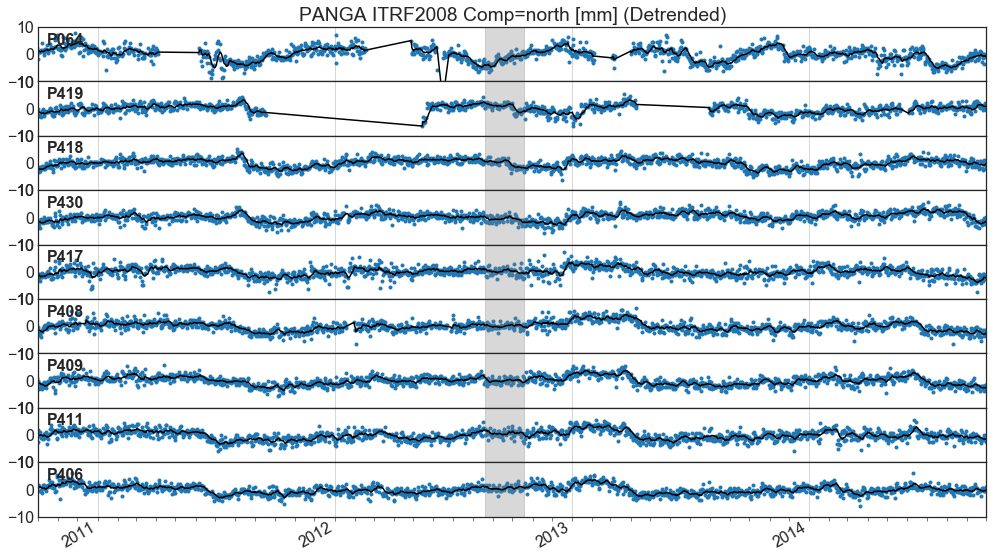

In [360]:
# N-S profile of GPS stations that should show ETS event
sites = ['P064', 'P419', 'P418', 'P430', 'P417', 'P408', 'P409', 'P411', 'P406']

comp = 'north'
fig,axes = plt.subplots(len(sites),1, sharex=True, sharey=True, figsize=(17,10))
for i,site in enumerate(sites):
    print(site)
    ax = axes[i]
    #tenv3 = gps.panga.download_data(site, overwrite=False)
    tmp = gps.panga.load_panga(site)
    #tmp = tmp['2010/10/01':'2014/10/01']#specific time range
    tmp = tmp.dropna()
    tmp = gps.analysis.do_detrend(tmp, comp, start='2010/08/01', end='2016/01/01')
    roll = tmp['detrend1_'+comp].rolling('10d').mean() #10day rolling mean
    ax.plot(roll.index, roll.values, 'k-')
    ax.scatter(tmp.index, tmp['detrend1_'+comp],marker='.',label=site)
    #ax.legend(loc='upper left', prop=dict(weight='bold'))
    ax.grid(axis='x')
    ax.set_ylim(-10,10)
    # Highlight strain increase
    #ax.axvspan(pd.to_datetime('2012/10/01'), pd.to_datetime('2012/10/30'), color='gray', alpha=0.3)
    #ax.axvspan(pd.to_datetime(start1), pd.to_datetime(end1), color='blue', alpha=0.3)
    #ax.axvspan(pd.to_datetime(start2), pd.to_datetime(end2), color='red', alpha=0.3)
    ax.axvspan(pd.to_datetime(startss), pd.to_datetime(endss), color='gray', alpha=0.3)
    ax.text(0.01, 0.9, site, fontsize=16, fontweight='extra bold', ha='left', va='top', transform=ax.transAxes)

months = pltdate.MonthLocator()
years = pltdate.YearLocator()
ax.xaxis.set_major_locator(years)
ax.xaxis.set_minor_locator(months) #too much
ax.fmt_xdata = pltdate.DateFormatter('%Y-%m-%d')
    
axes[0].set_title('PANGA ITRF2008 Comp={} [mm] (Detrended)'.format(comp))
fig.subplots_adjust(hspace=0, wspace=0)
fig.autofmt_xdate()
plt.tick_params(axis='x', which='minor', bottom=True, length=4)
plt.xlim(pd.to_datetime('2010/10/01'), pd.to_datetime('2014/10/01'))#specific time range
#plt.ylim(-10,10)



P064


/Users/scott/Documents/GitHub/gpstools/analysis.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df['ints'] = df.index.asi8
/Users/scott/Documents/GitHub/gpstools/analysis.py:59: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df['elapsed_s'] = (df.ints - df.ints[0])/1e9 #sec


up Rate [mm/yr]=1.2168501692395668
RMSE =  7.24382687093
P419


/Users/scott/Documents/GitHub/gpstools/analysis.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df['linear_{}'.format(col)] = est.predict(X)
/Users/scott/Documents/GitHub/gpstools/analysis.py:71: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df['detrend1_{}'.format(col)] = y - est.predict(X)


up Rate [mm/yr]=1.083468398937821
RMSE =  6.63551895274
P418
up Rate [mm/yr]=0.8440417194810426
RMSE =  6.74674528956
P430
up Rate [mm/yr]=-1.3704625815536993
RMSE =  7.33936165495
P417
up Rate [mm/yr]=-0.06583443900808682
RMSE =  6.82939314933
P408
up Rate [mm/yr]=0.2246626527951221
RMSE =  6.76515773081
P409
up Rate [mm/yr]=0.6538491515528372
RMSE =  6.53822640269
P411
up Rate [mm/yr]=0.9547834422846155
RMSE =  6.30417743427
P406
up Rate [mm/yr]=0.6290027136645658
RMSE =  5.09615905553


(734046.0, 735507.0)

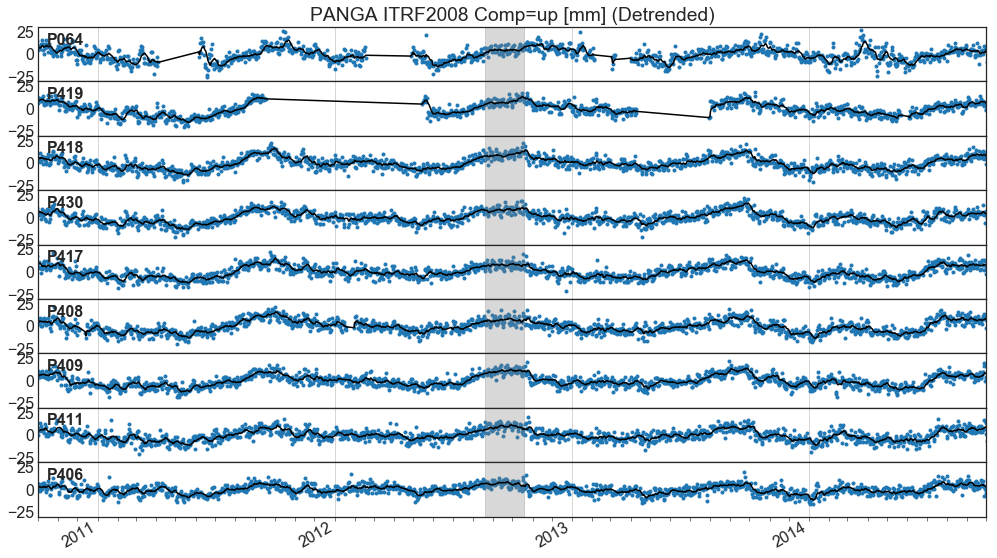

In [358]:
# N-S profile of GPS stations that should show ETS event
plt.rcParams['font.size'] = 16
sites = ['P064', 'P419', 'P418', 'P430', 'P417', 'P408', 'P409', 'P411', 'P406']

comp = 'up'
fig,axes = plt.subplots(len(sites),1, sharex=True, sharey=True, figsize=(17,10))
for i,site in enumerate(sites):
    print(site)
    ax = axes[i]
    #tenv3 = gps.panga.download_data(site, overwrite=False)
    tmp = gps.panga.load_panga(site)
    #tmp = tmp['2010/10/01':'2014/10/01']#specific time range
    tmp = tmp.dropna()
    tmp = gps.analysis.do_detrend(tmp, comp, start='2010/08/01', end='2016/01/01')
    roll = tmp['detrend1_'+comp].rolling('10d').mean() #10day rolling mean
    ax.plot(roll.index, roll.values, 'k-')
    ax.scatter(tmp.index, tmp['detrend1_'+comp],marker='.',label=site)
    #ax.legend(loc='upper left', prop=dict(weight='bold'))
    ax.grid(axis='x')
    ax.set_ylim(-30,30)
    # Highlight strain increase
    #ax.axvspan(pd.to_datetime('2012/10/01'), pd.to_datetime('2012/10/30'), color='gray', alpha=0.3)
    ax.axvspan(pd.to_datetime(startss), pd.to_datetime(endss), color='gray', alpha=0.3)
    #ax.axvspan(pd.to_datetime(start1), pd.to_datetime(end1), color='blue', alpha=0.3)
    #ax.axvspan(pd.to_datetime(start2), pd.to_datetime(end2), color='red', alpha=0.3)
    
    ax.text(0.01, 0.9, site, fontsize=16, fontweight='extra bold', ha='left', va='top', transform=ax.transAxes)
 
months = pltdate.MonthLocator()
years = pltdate.YearLocator()
ax.xaxis.set_major_locator(years)
ax.xaxis.set_minor_locator(months) #too much
ax.fmt_xdata = pltdate.DateFormatter('%Y-%m-%d')

axes[0].set_title('PANGA ITRF2008 Comp={} [mm] (Detrended)'.format(comp))
fig.subplots_adjust(hspace=0, wspace=0)
fig.autofmt_xdate()
plt.tick_params(axis='x', which='minor', bottom=True, length=4)
plt.xlim(pd.to_datetime('2010/10/01'), pd.to_datetime('2014/10/01'))#specific time range
#plt.ylim(-10,10)

P064


/Users/scott/Documents/GitHub/gpstools/analysis.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df['ints'] = df.index.asi8
/Users/scott/Documents/GitHub/gpstools/analysis.py:59: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df['elapsed_s'] = (df.ints - df.ints[0])/1e9 #sec


north Rate [mm/yr]=4.848200804794529
RMSE =  2.92645193987
P419


/Users/scott/Documents/GitHub/gpstools/analysis.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df['linear_{}'.format(col)] = est.predict(X)
/Users/scott/Documents/GitHub/gpstools/analysis.py:71: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df['detrend1_{}'.format(col)] = y - est.predict(X)


north Rate [mm/yr]=5.117367326665031
RMSE =  1.72810961522
P418
north Rate [mm/yr]=5.643927172278195
RMSE =  1.67403159663
P430
north Rate [mm/yr]=6.289631811511996
RMSE =  1.94462904389
P417
north Rate [mm/yr]=6.422225336420771
RMSE =  1.87487483971
P408
north Rate [mm/yr]=6.59926535965014
RMSE =  1.82782906749
P409
north Rate [mm/yr]=6.8138768735570165
RMSE =  1.76045356698
P411
north Rate [mm/yr]=6.575037638731895
RMSE =  1.82366337938
P406
north Rate [mm/yr]=6.75183200126005
RMSE =  1.67075573527


(734503.0, 734869.0)

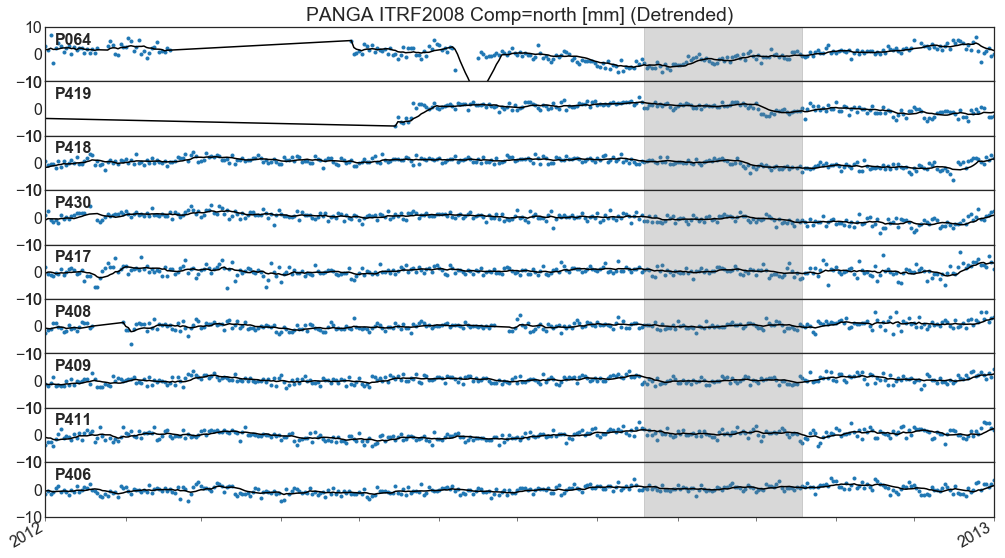

In [363]:
# Add rolling mean to timeseries, highlight strain transient
sites = ['P064', 'P419', 'P418', 'P430', 'P417', 'P408', 'P409', 'P411', 'P406']

comp = 'north'
fig,axes = plt.subplots(len(sites),1, sharex=True, sharey=True, figsize=(17,10))
for i,site in enumerate(sites):
    print(site)
    ax = axes[i]
    #tenv3 = gps.panga.download_data(site, overwrite=False)
    tmp = gps.panga.load_panga(site)
    #tmp = tmp['2010/10/01':'2014/10/01']#specific time range
    tmp = tmp.dropna()
    tmp = gps.analysis.do_detrend(tmp, comp, start='2010/08/01', end='2016/01/01')
    
    ax.scatter(tmp.index, tmp['detrend1_'+comp].values, marker='.')
    
    roll = tmp['detrend1_'+comp].rolling('10d').mean() #10day rolling mean
    ax.plot(roll.index, roll.values, 'k-')
    
    # Highlight entire slow slip event and strain increase
    ax.axvspan(pd.to_datetime(startss), pd.to_datetime(endss), color='gray', alpha=0.3)
    #ax.axvspan(pd.to_datetime(end1), pd.to_datetime(start2), color='yellow', alpha=0.3)
 
    #other annotations
    #ax.legend(loc='upper left', prop=dict(weight='bold'))
    ax.grid(axis='x')
    #ax.set_ylim(-30,30) #vertical
    ax.set_ylim(-10,10) #horizontals
    #ax.set_ylim(-5,5) #horizontal zoom 2012

    ax.text(0.01, 0.9, site, fontsize=16, fontweight='extra bold', ha='left', va='top', transform=ax.transAxes)

months = pltdate.MonthLocator()
years = pltdate.YearLocator()
ax.xaxis.set_major_locator(years)
ax.xaxis.set_minor_locator(months) #too much
ax.fmt_xdata = pltdate.DateFormatter('%Y-%m-%d')

axes[0].set_title('PANGA ITRF2008 Comp={} [mm] (Detrended)'.format(comp))
fig.subplots_adjust(hspace=0, wspace=0)
fig.autofmt_xdate()
plt.tick_params(axis='x', which='minor', bottom=True, length=4)


#plt.xlim(pd.to_datetime('2010/10/01'), pd.to_datetime('2014/10/01'))#specific time range
plt.xlim(pd.to_datetime('2012/01/01'), pd.to_datetime('2013/01/01'))#zoom in


In [ ]:
# Plot PANGA Seasonal fit info.

# Add Columbia river rain gauge info?


# Use UNGL solutions

P409


/Users/scott/Documents/GitHub/gpstools/analysis.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df['ints'] = df.index.asi8
/Users/scott/Documents/GitHub/gpstools/analysis.py:59: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df['elapsed_s'] = (df.ints - df.ints[0])/1e9 #sec


up Rate [mm/yr]=0.6538491515528372
RMSE =  6.53822640269
P410


/Users/scott/Documents/GitHub/gpstools/analysis.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df['linear_{}'.format(col)] = est.predict(X)
/Users/scott/Documents/GitHub/gpstools/analysis.py:71: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df['detrend1_{}'.format(col)] = y - est.predict(X)


up Rate [mm/yr]=0.3312686845997679
RMSE =  6.44074396582
P446
up Rate [mm/yr]=-0.5590268065178307
RMSE =  5.90349946676
P414
up Rate [mm/yr]=0.6303445131056331
RMSE =  6.19853338418
P412
up Rate [mm/yr]=1.0142814985260138
RMSE =  5.85986408824
P404
up Rate [mm/yr]=0.16729780363411417
RMSE =  6.06587429587


(734503.0, 734869.0)

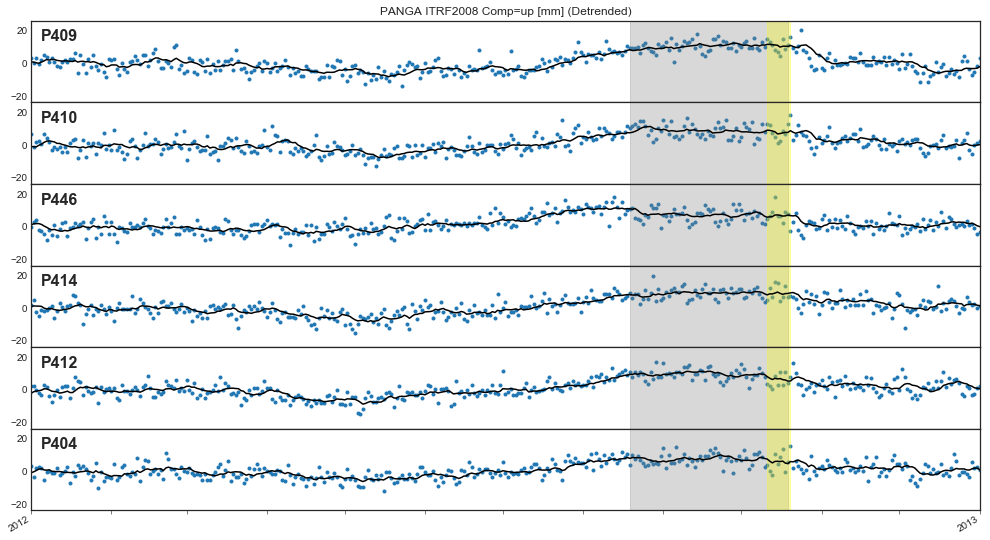

In [302]:
# Add rolling mean to timeseries, highlight strain transient
#sites = ['P064', 'P419', 'P418', 'P430', 'P417', 'P408', 'P409', 'P411', 'P406'] #123W
#sites = ['P402', 'P398', 'P415', 'P397', 'P407', 'SEAS', 'P405', 'P396', 'P395'] #124W
sites = ['P409', 'P410', 'P446', 'P414', 'P412', 'P404']  #cluster of stations around portland

comp = 'up'
fig,axes = plt.subplots(len(sites),1, sharex=True, sharey=True, figsize=(17,10))
for i,site in enumerate(sites):
    print(site)
    ax = axes[i]
    #tenv3 = gps.panga.download_data(site, overwrite=False)
    tmp = gps.panga.load_panga(site)
    #tmp = tmp['2010/10/01':'2014/10/01']#specific time range
    tmp = tmp.dropna()
    tmp = gps.analysis.do_detrend(tmp, comp, start='2010/08/01', end='2016/01/01')
    
    ax.scatter(tmp.index, tmp['detrend1_'+comp].values, marker='.')
    
    roll = tmp['detrend1_'+comp].rolling('10d').mean() #10day rolling mean
    ax.plot(roll.index, roll.values, 'k-')
    
    # Highlight entire slow slip event and strain increase
    ax.axvspan(pd.to_datetime(startss), pd.to_datetime(endss), color='gray', alpha=0.3)
    ax.axvspan(pd.to_datetime(end1), pd.to_datetime(start2), color='yellow', alpha=0.3)
 
    #other annotations
    #ax.legend(loc='upper left', prop=dict(weight='bold'))
    ax.grid(axis='x')
    #ax.set_ylim(-30,30) #vertical
    #ax.set_ylim(-10,10) #horizontals
    #ax.set_ylim(-5,5) #horizontal zoom 2012

    ax.text(0.01, 0.9, site, fontsize=16, fontweight='extra bold', ha='left', va='top', transform=ax.transAxes)

months = pltdate.MonthLocator()
years = pltdate.YearLocator()
ax.xaxis.set_major_locator(years)
ax.xaxis.set_minor_locator(months) #too much
ax.fmt_xdata = pltdate.DateFormatter('%Y-%m-%d')

axes[0].set_title('PANGA ITRF2008 Comp={} [mm] (Detrended)'.format(comp))
fig.subplots_adjust(hspace=0, wspace=0)
fig.autofmt_xdate()
plt.tick_params(axis='x', which='minor', bottom=True, length=4)


#plt.xlim(pd.to_datetime('2010/10/01'), pd.to_datetime('2014/10/01'))#specific time range
plt.xlim(pd.to_datetime('2012/01/01'), pd.to_datetime('2013/01/01'))#zoom in



In [ ]:
# Save 14-day position averages
# Use diff() command to get 'instantaneously velocity between each period
# Create Vector Map Animation